# 1. Insights & Comparison

In [1]:
# Load Data from OracleDB

import sys
import os
import pandas as pd

# Try different paths if needed
sys.path.append(os.path.abspath("../src"))

# Import the function to get the database engine
from database import get_engine

# Connect to OracleDB
engine = get_engine()

df = pd.read_sql("SELECT * FROM bank_review_analysis", con=engine)
df.head()

,app_name,rating,review_translated,sentiment_score,sentiment_label,keywords,themes
0,Commercial Bank of Ethiopia,1.0,አዛ,0.697,NEGATIVE,None,User Experience
1,Commercial Bank of Ethiopia,5.0,wow simple life,1.000,POSITIVE,None,User Experience
2,Commercial Bank of Ethiopia,5.0,it's nice,1.000,POSITIVE,None,Banking & Transactions
3,Commercial Bank of Ethiopia,5.0,Why stacked sometimes,0.994,NEGATIVE,None,User Experience
4,Commercial Bank of Ethiopia,1.0,okay 👍 but sometimes busy,0.852,NEGATIVE,None,App Identity


## Identify Top Drivers and Top Pain Points

In [2]:
import ast

def safe_convert_to_list(x):
    try:
        # Try to parse list-like strings
        if isinstance(x, str):
            x = x.strip()
            if x.startswith('[') and x.endswith(']'):
                return ast.literal_eval(x)
            else:
                return [x]  # Wrap plain string into list
        elif isinstance(x, list):
            return x
        else:
            return []
    except:
        return []

df['themes'] = df['themes'].apply(safe_convert_to_list)


In [3]:
exploded = df.explode('themes')

theme_sentiment_counts = (
    exploded.groupby(['sentiment_label', 'themes'])
    .size()
    .reset_index(name='count')
    .sort_values(['sentiment_label', 'count'], ascending=[True, False])
)

top_drivers = theme_sentiment_counts[theme_sentiment_counts['sentiment_label'] == 'POSITIVE'].head(5)
top_pain_points = theme_sentiment_counts[theme_sentiment_counts['sentiment_label'] == 'NEGATIVE'].head(5)

top_drivers, top_pain_points


(   sentiment_label                  themes  count
 10        POSITIVE                   Other     34
 11        POSITIVE         User Experience     19
 8         POSITIVE  Banking & Transactions     11
 7         POSITIVE         App Performance      9
 6         POSITIVE            App Identity      8,
   sentiment_label                  themes  count
 4        NEGATIVE                   Other     24
 5        NEGATIVE         User Experience     13
 1        NEGATIVE         App Performance     12
 0        NEGATIVE            App Identity      7
 2        NEGATIVE  Banking & Transactions      6)

## Compare Sentiment Distribution Across Banks

In [4]:
sentiment_by_bank = (
    df.groupby(['app_name', 'sentiment_label'])
    .size()
    .reset_index(name='count')
    .pivot(index='app_name', columns='sentiment_label', values='count')
    .fillna(0)
    .astype(int)
)

sentiment_by_bank


sentiment_label,NEGATIVE,NEUTRAL,POSITIVE
app_name,,,
BoA Mobile,1163,351,592
Commercial Bank of Ethiopia,791,362,1049
Dashen Bank,505,367,1330



## Key Insights and Recommendations

### Top Drivers (Positive Sentiment Themes)
Based on the analysis, the main positive themes driving customer satisfaction are:
1. User Experience (19 reviews) - Customers appreciate the overall user interface and ease of use
2. Banking & Transactions (11 reviews) - Positive feedback on core banking functionality
3. App Performance (9 reviews) - Good app speed and reliability
4. App Identity (8 reviews) - Strong brand recognition and trust

### Pain Points (Negative Sentiment Themes)
The main areas of customer dissatisfaction are:
1. User Experience (13 reviews) - Issues with interface design and usability
2. App Performance (12 reviews) - Problems with app speed, crashes, and reliability
3. App Identity (7 reviews) - Concerns about brand trust and security
4. Banking & Transactions (6 reviews) - Difficulties with core banking features

### Recommendations for App Improvements
1. **Enhance User Experience**
    - Conduct user testing to identify specific pain points in the interface
    - Implement a more intuitive navigation system
    - Add user onboarding tutorials for new features

2. **Optimize App Performance**
    - Invest in infrastructure to improve app speed and stability
    - Implement better error handling and recovery mechanisms
    - Add offline functionality for critical features

3. **Strengthen Security and Trust**
    - Enhance security features and make them more visible to users
    - Improve communication about security measures
    - Add more transparent transaction tracking features

### Bank-Specific Insights
The sentiment analysis across banks shows:
 - Dashen Bank has the highest positive sentiment (1330 positive reviews)
 - Commercial Bank of Ethiopia has a balanced sentiment distribution
 - BoA Mobile shows higher negative sentiment (1163 negative reviews)

These insights suggest opportunities for cross-bank learning and implementation of best practices.


---

# 2. Visualization

### 1. Sentiment Distribution by Bank

<Figure size 1200x600 with 0 Axes>

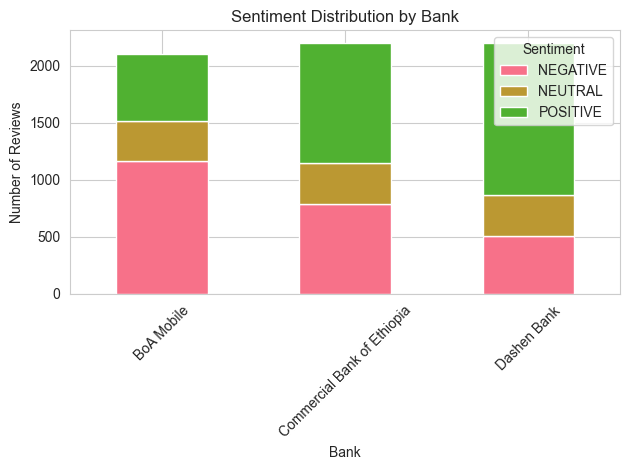

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

# Set style - using seaborn's built-in style
sns.set_style("whitegrid")
sns.set_palette("husl")

# 1. Sentiment Distribution by Bank
plt.figure(figsize=(12, 6))
sentiment_by_bank = df.groupby(['app_name', 'sentiment_label']).size().unstack()
sentiment_by_bank.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Bank')
plt.xlabel('Bank')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### 2. Top Themes by Sentiment

<Figure size 1200x600 with 0 Axes>

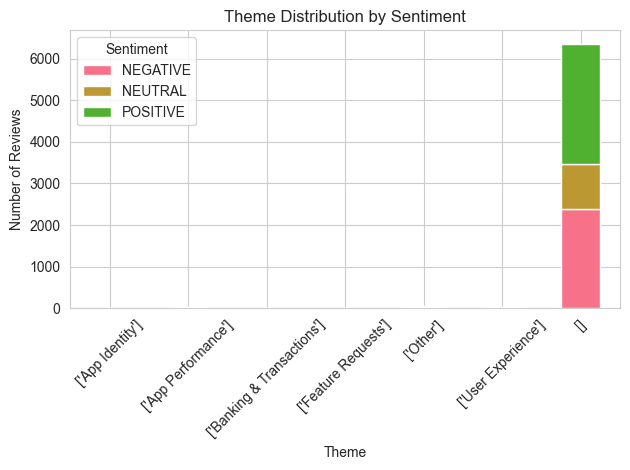

In [6]:
# 2. Top Themes by Sentiment
plt.figure(figsize=(12, 6))
# Convert themes to string if they are lists
df['themes'] = df['themes'].astype(str)
theme_sentiment = df.groupby(['themes', 'sentiment_label']).size().unstack()
theme_sentiment.plot(kind='bar', stacked=True)
plt.title('Theme Distribution by Sentiment')
plt.xlabel('Theme')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3. Word Clouds per Bank

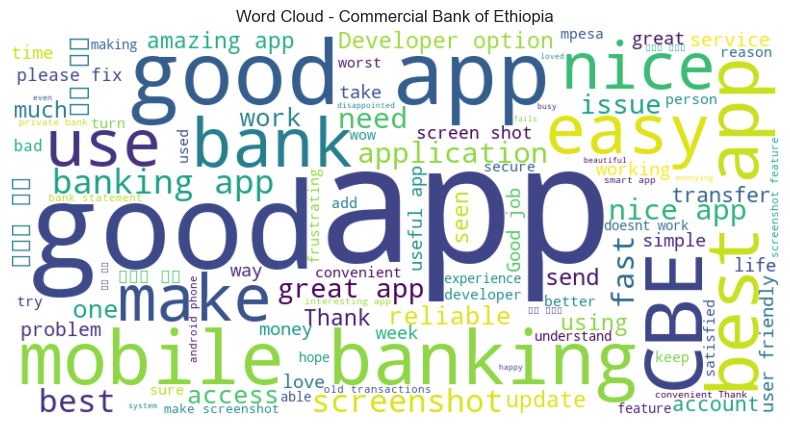

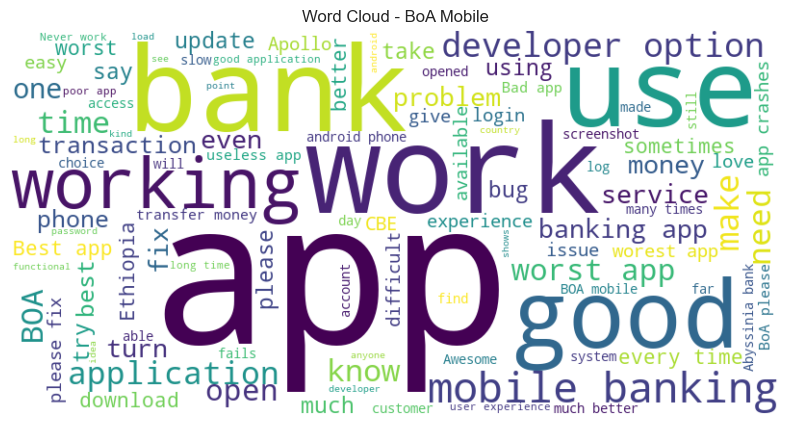

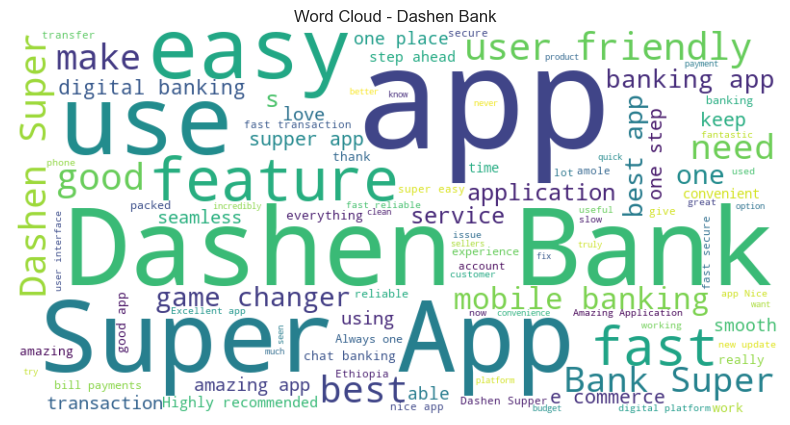

In [8]:
# 3. Word Clouds per Bank
def generate_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         max_words=100).generate(' '.join(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds for each bank
for bank in df['app_name'].unique():
    bank_reviews = df[df['app_name'] == bank]['review_translated'].dropna()
    generate_wordcloud(bank_reviews, f'Word Cloud - {bank}')



### 4. Sentiment Distribution by Rating

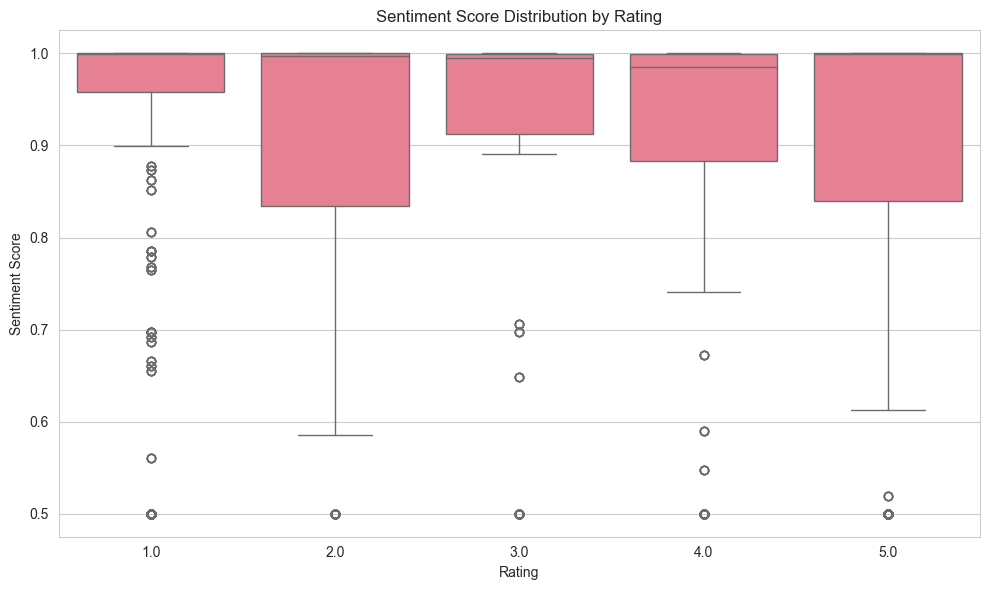

In [9]:
# 4. Sentiment Distribution by Rating
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='rating', y='sentiment_score')
plt.title('Sentiment Score Distribution by Rating')
plt.xlabel('Rating')
plt.ylabel('Sentiment Score')
plt.tight_layout()
plt.show()

---

# 3. Ethical Considerations in Our Analysis

## Data Collection Limitations
- **Selection Bias**: Our analysis only includes reviews from Google Play Store users, which may not represent the entire user base
  - Excludes iOS users (App Store)
  - May underrepresent users who don't leave reviews
  - Could miss important feedback from non-Play Store users

## Sentiment Analysis Limitations
- **Language Challenges**:
  - Reviews in multiple languages (including Amharic) may not be perfectly translated
  - Cultural context and local expressions may be lost in translation
  - Sarcasm and idioms may be misinterpreted by the sentiment model

- **Model Limitations**:
  - Binary sentiment classification may oversimplify complex feedback
  - Model may not capture nuanced emotions or mixed feelings
  - Potential bias in training data affecting sentiment scores

## Recommendations for Future Analysis
- Include App Store reviews for more comprehensive coverage
- Consider manual review of sentiment classifications for accuracy
- Implement more sophisticated sentiment analysis that can handle:
  - Multiple languages natively
  - Cultural context
  - Sarcasm and idioms
  - Mixed emotions
